In [1]:
%run ./_setup.ipynb

# Make buoy data file

Standardize buoy data and put it together in a Pandas dataframe.

Most of the data is read from the TABS website using the [`tabs` package from github](https://github.com/kthyng/tabs.git). Sometimes the stations won't all read in and you may have to rerun the script several times. It takes awhile to run.

Use MHW for tidal level data to match bathymetry datum.

This notebook downloads the necessary shapefiles for the map: lakes/rivers.

In [2]:
savename = based + 'data.csv'
dstart = '2014-01-01'; dend = '2019-1-1'
tz = 'UTC'  # timezone

In [3]:
if not os.path.exists(savename):

    ## Stream gauges. Data brought in from USGS.
    stations = ['08078000', '08074500', '08066500','08067500','08075770','08075000','08076500',
                '08076000','08073600','08075730', '08077600', '08068090', '08067252']  
    df = tabs.read(stations, dstart, dend, resample=('15T',0,'instant',False))
              
    ## Gauge height. From USGS.
    station = '08072000'
    df = df.join(tabs.read(station, dstart, dend, resample=('15T',0,'instant',False), var='height'))
              
    ## Reservoir storage. From USGS.
    station = '08072000'
    df = df.join(tabs.read(station, dstart, dend, resample=('15T',0,'instant',False), var='storage'))

    ## TWDB data
    names = ['FISH', 'MIDG', 'TRIN', 'BOLI']
    for name  in names:
        df = df.join(tabs.read(name, dstart, dend, resample=('15T',0,'instant',False)))
            
    ## NOS/NDBC buoys
    stations = ['8771486','8770613','8771013','8771341','8770777']
    for station in stations:
        df = df.join(tabs.read(station, dstart, dend, resample=('15T',0,'instant',False), datum='MHW'))
              
    ## ADCP profile. From NOAA CO-OPS.
    adcp = tabs.read('g06010_full', dstart, dend, resample=('15T',0,'mean',False))
    
    # Calculate mean speed for velocity profile at entrance channel and save into df
    # We have velocity information with depth, but are missing the bottom of the water column and about 
    # the top half due to the blanking distance and mount depth. We calculate the mean for each profile 
    # assuming the velocity is constant above the top-most data and assuming the bottom goes to 0 speed 
    # in 12 meters of water.
    dates = df.index
    smean = np.zeros(dates.size)
    smean2 = np.zeros(dates.size)
    smean3 = np.zeros(dates.size)
    zmean = np.zeros(dates.size)
    depths = adcp['Depth to top of bin [m]'].unique()[:-1]
    depths_smean = np.hstack((0,depths,-12))  # include top and bottom of water column bc will specify values for smean
    # interpolate to fill in water column evenly
    zint = np.linspace(-12, 0, 1000)  # depths

    for i, date in enumerate(dates):

        if not date in adcp.index:
            continue
            
        # For polynomial fits, do whole water column at once; Change to m/s from cm/s
        s = adcp.loc[date,'Along [cm/s] (water)']/100

        # check for nans
        if s.isnull().all():
            smean[i] = np.nan
            zmean[i] = np.nan
            smean2[i] = np.nan
            smean3[i] = np.nan
        else:

            s_mean = np.hstack((s[0],s,0))  # add values for top and bottom of water column
            sint = np.interp(zint, depths_smean[::-1], s_mean[::-1])
            smean[i] = sint.mean()  # mean speed for profile
            zmean[i] = zint[abs(sint - sint.mean()).argmin()]  # depth at which mean occurs

            p2 = np.polyfit(depths, s, 2)
            smean2[i] = np.polyval(p2, zint).mean()
            p3 = np.polyfit(depths, s, 3)
            smean3[i] = np.polyval(p3, zint).mean()
         
    # add into dataframe
    df['smean'] = smean
    df['smean_2nd'] = smean2
    df['smean_3rd'] = smean3
    df['zmean'] = zmean
            
    ## Also include single time series, for comparison. From NOAA PORTS.
    df = df.join(tabs.read('g06010', dstart, dend, resample=('15T',0,'mean',False)))
    
    ## Precipitation data from TX Water Science Center
    ## this data is locally saved because it is not freely available online after 120 days.
    stations = ['08067000', '08077650', '08073600']
    for station in stations:
        # rain is in inches
        rain = pd.read_csv(based + station + '-precip.csv', comment='#', parse_dates=True, index_col=0, usecols=[0,2])#.tz_localize('UTC')
        rain *= 2.54  # convert from inches to centimeters
        df[station + ': Rain [cm]'] = rain
            
    df = df.tz_localize(None)
    df.to_csv(savename)  # save as a csv file
else:
    df = pd.read_csv(savename, parse_dates=True, index_col=0)

In [4]:
# These definitions are used for the plot below

plots = {'Water Level [m]': {'color': '0.1', 'marker': 'o', 's': 170, 'alpha': 1, 'linewidths': 2}, 
         'Gage height [m]': {'marker': 'o', 's': 200, 'alpha': 1}, 
         'East [m/s]': {'color': 'w', 'marker': 'v', 's': 120, 'alpha': 1},
         'Salinity': {'color': 'w', 'marker': '*', 's': 280, 'alpha': 1}, 
         'Along [cm/s]': {'color': 'w', 'marker': '^', 's': 150, 'alpha': 1},
         'Rain [cm]': {'marker': 's', 's':170, 'alpha': 1, 'color': '0.4'},
         'Flow rate [m^3/s]': {'marker': '>', 's': 160, 'alpha': 1, 'color': 'w'}}

buoyfont = 12
buoytextcolor = 'k'

In [5]:
# download shapefiles for rivers and move
if not os.path.exists('%s/TCEQ_Segments_Line_shp/' % basesf):
    !wget https://www.tceq.texas.gov/assets/public/gis/exports/TCEQ_Segments_Line_shp.zip
    unpack_archive('TCEQ_Segments_Line_shp.zip', '%s/TCEQ_Segments_Line_shp/' % basesf)

In [6]:
# download shapefiles for lakes and move
if not os.path.exists('%s/TCEQ_Segments_Poly_shp/' % basesf):
    !wget https://www.tceq.texas.gov/assets/public/gis/exports/TCEQ_Segments_Poly_shp.zip
    unpack_archive('TCEQ_Segments_Poly_shp.zip', '%s/TCEQ_Segments_Poly_shp/' % basesf)

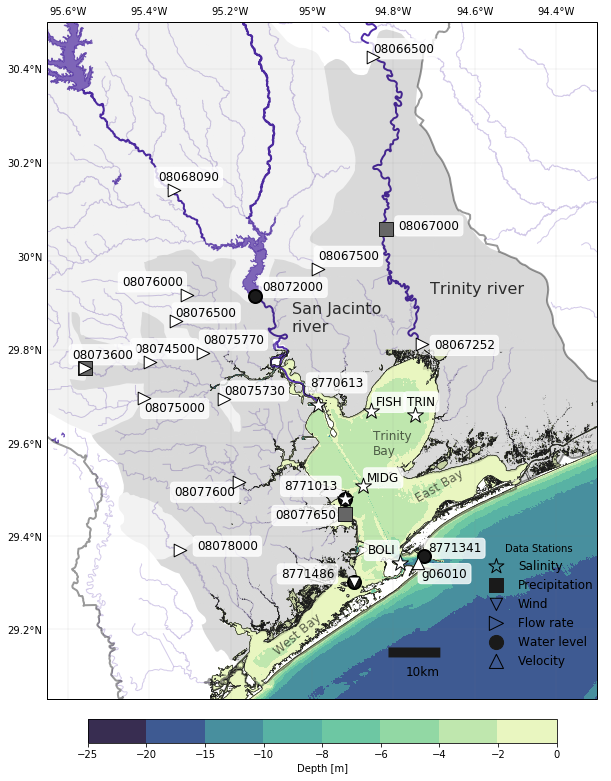

In [7]:
# extent of plot left/right and up/down
extent = [-95.65, -94.3, 29.05, 30.5]
x1, x2, y1, y2 = extent
pts = np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])
ext = shapely.geometry.Polygon(pts)

fig = plt.figure(figsize=(14, 12))# (9.4, 7.7))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_extent(extent, pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.2))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.2))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry, but only near bay
mappable = ax.contourf(bathy['lon'], bathy['lat'], bathy['all'], [-25, -20, -15, -10, -8, -6, -4, -2, 0], cmap=cmo.deep_r, transform=pc)
cb = fig.colorbar(mappable, orientation='horizontal', shrink=0.5, pad=0.025)
cb.set_label('Depth [m]')

# add bay-area detailed coastline
ax.contour(bathy['lon'], bathy['lat'], bathy['mask'], 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

## Lakes ##
reader = cartopy.io.shapereader.Reader(basesf + 'TCEQ_Segments_Poly_shp/tceq_segments_shp/TCEQ_Segments_Poly.shp')
lakes = reader.records()
for lake in lakes:
    if ext.contains(lake.geometry.centroid) and "Bay" not in lake.attributes['BASIN_NAME'] \
         and "Gulf" not in lake.attributes['BASIN_NAME']:
        ax.add_geometries([lake.geometry], pc, facecolor=watercolor, edgecolor=watercolor, alpha=0.7)

## Rivers ##
reader = cartopy.io.shapereader.Reader(basesf + 'TCEQ_Segments_Line_shp/tceq_segments_shp/TCEQ_Segments_Line.shp')
rivers = reader.records()
for river in rivers:
    if 'San Jacinto' in river.attributes['SEG_NAME'] or 'Trinity' in river.attributes['SEG_NAME']:
        alpha = 1; lw = 2
    else:
        alpha = 0.25; lw = 1
    if ext.contains(river.geometry.centroid):
        ax.add_geometries([river.geometry], pc, facecolor='none', edgecolor=watercolor, alpha=alpha, linewidth=lw)
        

## TWDB river basins ##
# twdbshapes = 'galv_ws_nad83_prj_albers_equal_area_conic_USGS'
# fname = '%s%s/%s.shp' % (basesf, twdbshapes, twdbshapes)
# reader = cartopy.io.shapereader.Reader(fname)
# basins = reader.records()
# spgbs = []
# for basin in basins:
#     if basin.attributes['WS_ID'] in idgb:
#         spgbs.append(basin)
for basin in shapes_twdbbasins:
    wstype = basin.attributes['WS_type'].split(' ')[0]
    if wstype == 'Gauged':  # lightest grey
        alpha = 0.05
    elif wstype == 'Bay':  # white
        alpha = 0.0
    elif wstype == 'Ungauged' or wstype == 'Ungaged':  # grey
        alpha = 0.15
    ax.add_geometries([basin.geometry], aea, facecolor='k', edgecolor='none', alpha=alpha)
# outline full watershed region
ax.add_geometries([shapes_gbay_full], pc, facecolor='none', edgecolor='k', alpha=0.4, linewidth=2)
    
    
## Precipitation
var = 'Rain [cm]'
kwargs = plots[var]
for buoy in ['08067000', '08077650', '08073600']:
    ax.scatter(*buoys[buoy]['ll'], **kwargs, transform=pc, label=var, edgecolors='0.1', zorder=5)
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    if not buoy == '08073600':  # will be labeled by river flow
        ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=buoyfont, color=buoytextcolor, bbox=props)


## river flow
reader = cartopy.io.shapereader.Reader(basesf + 'usgs_gauges_clipped_galv_ws_albers_equal_area_conic.shp/usgs_gauges_clipped_galv_ws_albers_equal_area_conic.shp')
gauges = reader.records()
var = 'Flow rate [m^3/s]'
kwargs = plots[var]
for gauge in gauges:
    buoy = gauge.attributes['ID']
    if buoy not in ['08077000','08075500','08072000']:
#         ll = gauge.geometry.xy
        # use lon/lat from my file so is not in aea
        ax.scatter(*buoys[buoy]['ll'], **kwargs, transform=pc, label=var, edgecolors='k', zorder=5)
        try:
            lonsh, latsh = buoys[buoy]['llshift']
        except:
            lonsh, latsh = 0.01, 0.01
        llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
        ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=buoyfont, color=buoytextcolor, bbox=props)
for buoy in ['08077600', '08068090', '08067252']:
    ax.scatter(*buoys[buoy]['ll'], **kwargs, transform=pc, label=var, edgecolors='k', zorder=5)
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=buoyfont, color=buoytextcolor, bbox=props)

        
## Water level
var = 'Water Level [m]'
kwargs = plots[var]
for buoy in ['8771013', '8771486', '08072000', '8771341']:
    ax.scatter(*buoys[buoy]['ll'], **kwargs, transform=pc, label=var, edgecolors='k', zorder=5)
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    # others will be labeled by others
    if buoy in ['08072000', '8771341']:
        ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=buoyfont, color=buoytextcolor, bbox=props)

## Salinity
var = 'Salinity'
kwargs = plots[var]
for buoy in ['TRIN', 'MIDG', 'BOLI', 'FISH', '8770613', '8771013']:
    ax.scatter(*buoys[buoy]['ll'], **kwargs, transform=pc, label=var, edgecolors='k', zorder=5)
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=buoyfont, color=buoytextcolor, bbox=props)

## Wind
var = 'East [m/s]'
kwargs = plots[var]
for buoy in ['8771486']:
    ax.scatter(*buoys[buoy]['ll'], **kwargs, transform=pc, label=var, edgecolors='k', zorder=5)
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=buoyfont, color=buoytextcolor, bbox=props)

# Currents
var = 'Along [cm/s]'
buoy = 'g06010'
kwargs = plots[var]
ax.scatter(*buoys[buoy]['ll'], **kwargs, transform=pc, label=var, edgecolors='k', zorder=5)
try:
    lonsh, latsh = buoys[buoy]['llshift']
except:
    lonsh, latsh = 0.01, 0.01
llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=buoyfont, color=buoytextcolor, bbox=props)

# add labels
ax.text(-94.71, 29.92, 'Trinity river', fontsize=16, transform=pc, alpha=0.8)
ax.text(-95.05, 29.84, 'San Jacinto\nriver', fontsize=16, transform=pc, alpha=0.8)
ax.text(-94.85, 29.575, 'Trinity\nBay', fontsize=12, transform=pc, alpha=0.6)
ax.text(-94.75, 29.55, 'East Bay', fontsize=12, transform=pc, alpha=0.6, rotation=30, horizontalalignment='left', verticalalignment='top')
ax.text(-95.1, 29.24, 'West Bay', fontsize=12, transform=pc, alpha=0.6, rotation=40, horizontalalignment='left', verticalalignment='top')

# Distance key
llon, llat = -94.8, 29.15
eqproj = cartopy.crs.AzimuthalEquidistant(central_longitude=-95, central_latitude=30)
lx, ly = eqproj.transform_point(llon, llat, pc)  # convert to projection
ax.plot([lx, lx+10e3], [ly, ly], lw=10, transform=eqproj, color='0.1')
ax.text(llon+0.03, llat-0.05, '10km', transform=pc, fontsize=12)

# Add legend
ax2 = fig.add_axes([0.675, 0.2, 0.13, 0.3], frameon=False)
ax2.scatter([], [], c='none', linewidths=1, s=250, marker='*', edgecolors='k', label='Salinity')
ax2.scatter([], [], c='0.1', s=200, marker='s', label='Precipitation')
ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=150, marker='v', label='Wind')
ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=200, marker='>', label='Flow rate')
ax2.scatter([], [], c='0.1', s=200, marker='o', label='Water level')
ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=200, marker='^', label='Velocity', alpha=1)

ax2.legend(scatterpoints=1, frameon=False, title='Data Stations', loc='lower right', fontsize=buoyfont)
ax2.set_axis_off()

fig.savefig('../figures/map.png', bbox_inches='tight', dpi=300)
fig.savefig('../figures/map_lowres.png', bbox_inches='tight')